In [5]:
from google.colab import files
uploaded = files.upload()


Saving archive (2).zip to archive (2).zip


In [6]:
import zipfile

zip_path = "/content/archive (2).zip"
extract_to = "/content/dataset-resized"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("Extracted to:", extract_to)


Extracted to: /content/dataset-resized


In [7]:
!pip -q install -U gradio scikit-learn matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.3/325.3 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 40.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 38.6 MB/s eta 0:00:00


In [8]:
# fresh clone
!rm -rf /content/trashnet /content/waste_data
!git clone https://github.com/garythung/trashnet /content/trashnet

# unzip the dataset that lives inside the repo
!unzip -q "/content/trashnet/data/dataset-resized.zip" -d "/content/trashnet/data/"

# verify classes
!ls -1 /content/trashnet/data/dataset-resized


Cloning into '/content/trashnet'...
remote: Enumerating objects: 45, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 45 (delta 6), reused 0 (delta 0), pack-reused 33 (from 1)
Receiving objects: 100% (45/45), 40.64 MiB | 14.42 MiB/s, done.
Resolving deltas: 100% (12/12), done.
cardboard
glass
metal
paper
plastic
trash


In [9]:
import os, glob, shutil, numpy as np, tensorflow as tf
from sklearn.model_selection import train_test_split

SEED=42
DATA_SRC = "/content/trashnet/data/dataset-resized"
BASE = "/content/waste_data"
for p in ["train","val","test"]:
    os.makedirs(os.path.join(BASE,p), exist_ok=True)

classes = sorted([d for d in os.listdir(DATA_SRC) if os.path.isdir(os.path.join(DATA_SRC,d))])
all_paths, all_labels = [], []
for c in classes:
    ps = sorted(glob.glob(os.path.join(DATA_SRC, c, "*.jpg")))
    all_paths += ps; all_labels += [c]*len(ps)

train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    all_paths, all_labels, test_size=0.20, random_state=SEED, stratify=all_labels)
val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels, test_size=0.50, random_state=SEED, stratify=temp_labels)

def _copy(paths, labels, split):
    for src, lab in zip(paths, labels):
        tgt = os.path.join(BASE, split, lab)
        os.makedirs(tgt, exist_ok=True)
        shutil.copy(src, os.path.join(tgt, os.path.basename(src)))

_copy(train_paths, train_labels, "train")
_copy(val_paths,   val_labels,   "val")
_copy(test_paths,  test_labels,  "test")

print("Classes:", classes)
print("Counts train/val/test:", len(train_paths), len(val_paths), len(test_paths))

Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
Counts train/val/test: 2021 253 253


In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

AUTOTUNE=tf.data.AUTOTUNE
IMG_SIZE=(224,224); BATCH=32

def make_ds(folder, shuffle):
    return tf.keras.utils.image_dataset_from_directory(
        folder, labels="inferred", label_mode="int", class_names=classes,
        image_size=IMG_SIZE, batch_size=BATCH, shuffle=shuffle, seed=SEED)

train_ds = make_ds(os.path.join(BASE,"train"), True)
val_ds   = make_ds(os.path.join(BASE,"val"),   False)
test_ds  = make_ds(os.path.join(BASE,"test"),  False)

norm = layers.Rescaling(1./255)
augment = keras.Sequential([
    layers.RandomFlip("horizontal", seed=SEED),
    layers.RandomRotation(0.05, seed=SEED),
    layers.RandomZoom(0.1, seed=SEED),
    layers.RandomContrast(0.1, seed=SEED),
])

def prep(ds, aug=False):
    ds = ds.map(lambda x,y: (norm(tf.cast(x, tf.float32)), y), num_parallel_calls=AUTOTUNE)
    if aug: ds = ds.map(lambda x,y: (augment(x, training=True), y), num_parallel_calls=AUTOTUNE)
    return ds.prefetch(AUTOTUNE)

train_ds = prep(train_ds, aug=True)
val_ds   = prep(val_ds,   aug=False)
test_ds  = prep(test_ds,  aug=False)

Found 2021 files belonging to 6 classes.
Found 253 files belonging to 6 classes.
Found 253 files belonging to 6 classes.


In [11]:
base = tf.keras.applications.EfficientNetB0(include_top=False, weights="imagenet", input_shape=IMG_SIZE+(3,))
base.trainable=False
inp = keras.Input(shape=IMG_SIZE+(3,))
x = tf.keras.applications.efficientnet.preprocess_input(inp*255.0)
x = base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.25)(x)
out = layers.Dense(len(classes), activation="softmax")(x)
model = keras.Model(inp, out)

INIT_LR=1e-3; FT_LR=2e-4
model.compile(optimizer=keras.optimizers.Adam(INIT_LR),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=["accuracy"])

ckpt_dir="/content/checkpoints"; os.makedirs(ckpt_dir, exist_ok=True)
ckpt = keras.callbacks.ModelCheckpoint(os.path.join(ckpt_dir,"best.keras"),
                                       monitor="val_accuracy", mode="max",
                                       save_best_only=True, verbose=1)
es = keras.callbacks.EarlyStopping(monitor="val_accuracy", mode="max",
                                   patience=4, restore_best_weights=True)
reduce = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5,
                                           patience=2, verbose=1)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [12]:
print("Warmup...")
EPOCHS_WARMUP=3
model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS_WARMUP,
          callbacks=[ckpt, es, reduce], verbose=2)


Warmup...
Epoch 1/3

Epoch 1: val_accuracy improved from -inf to 0.79051, saving model to /content/checkpoints/best.keras
64/64 - 226s - 4s/step - accuracy: 0.6116 - loss: 1.0814 - val_accuracy: 0.7905 - val_loss: 0.6511 - learning_rate: 1.0000e-03
Epoch 2/3

Epoch 2: val_accuracy improved from 0.79051 to 0.83794, saving model to /content/checkpoints/best.keras
64/64 - 196s - 3s/step - accuracy: 0.7947 - loss: 0.6058 - val_accuracy: 0.8379 - val_loss: 0.5149 - learning_rate: 1.0000e-03
Epoch 3/3

Epoch 3: val_accuracy did not improve from 0.83794
64/64 - 212s - 3s/step - accuracy: 0.8333 - loss: 0.4912 - val_accuracy: 0.8379 - val_loss: 0.4567 - learning_rate: 1.0000e-03


In [13]:
from tensorflow.keras import layers as L
for l in base.layers[-60:]:
    if not isinstance(l, L.BatchNormalization):
        l.trainable=True

model.compile(optimizer=keras.optimizers.Adam(FT_LR),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=["accuracy"])

print("Finetune...")
EPOCHS_FINETUNE=10
model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS_FINETUNE,
          callbacks=[ckpt, es, reduce], verbose=2)

best_model = keras.models.load_model(os.path.join(ckpt_dir,"best.keras"))


Finetune...
Epoch 1/10

Epoch 1: val_accuracy improved from 0.83794 to 0.86561, saving model to /content/checkpoints/best.keras
64/64 - 264s - 4s/step - accuracy: 0.8476 - loss: 0.4249 - val_accuracy: 0.8656 - val_loss: 0.3170 - learning_rate: 2.0000e-04
Epoch 2/10

Epoch 2: val_accuracy improved from 0.86561 to 0.87352, saving model to /content/checkpoints/best.keras
64/64 - 254s - 4s/step - accuracy: 0.9317 - loss: 0.1972 - val_accuracy: 0.8735 - val_loss: 0.3346 - learning_rate: 2.0000e-04
Epoch 3/10

Epoch 3: val_accuracy improved from 0.87352 to 0.89723, saving model to /content/checkpoints/best.keras

Epoch 3: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-05.
64/64 - 251s - 4s/step - accuracy: 0.9570 - loss: 0.1268 - val_accuracy: 0.8972 - val_loss: 0.3214 - learning_rate: 2.0000e-04
Epoch 4/10

Epoch 4: val_accuracy did not improve from 0.89723
64/64 - 245s - 4s/step - accuracy: 0.9842 - loss: 0.0639 - val_accuracy: 0.8933 - val_loss: 0.2760 - learning_rate: 1.0

              precision    recall  f1-score   support

   cardboard     0.9756    0.9756    0.9756        41
       glass     0.9400    0.9400    0.9400        50
       metal     0.8667    0.9512    0.9070        41
       paper     0.9153    0.9153    0.9153        59
     plastic     0.9574    0.9184    0.9375        49
       trash     0.9091    0.7692    0.8333        13

    accuracy                         0.9289       253
   macro avg     0.9273    0.9116    0.9181       253
weighted avg     0.9299    0.9289    0.9287       253



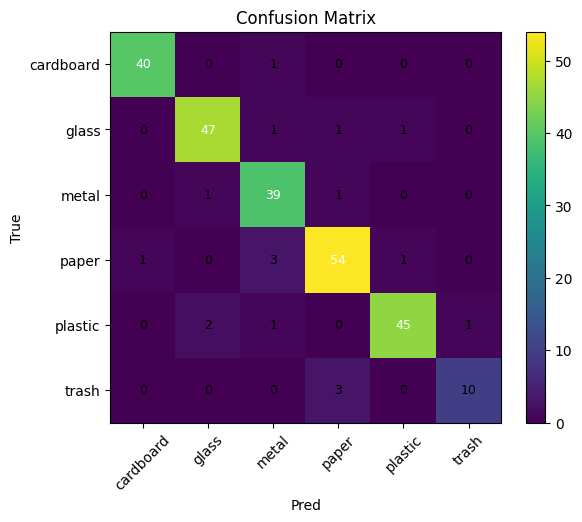

Test Accuracy: 0.9288537549407114


In [14]:
import numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

y_true, y_prob = [], []
for xb, yb in test_ds:
    y_true.extend(yb.numpy().tolist())
    y_prob.extend(best_model.predict(xb, verbose=0).tolist())
y_true=np.array(y_true); y_prob=np.array(y_prob); y_pred=y_prob.argmax(1)

print(classification_report(y_true, y_pred, target_names=classes, digits=4))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5)); plt.imshow(cm); plt.title("Confusion Matrix"); plt.colorbar()
ticks=np.arange(len(classes)); plt.xticks(ticks, classes, rotation=45); plt.yticks(ticks, classes)
thr=cm.max()/2
for i in range(cm.shape[0]):
  for j in range(cm.shape[1]):
    plt.text(j,i,cm[i,j],ha="center",va="center",
             color="white" if cm[i,j]>thr else "black", fontsize=9)
plt.tight_layout(); plt.xlabel("Pred"); plt.ylabel("True"); plt.show()
print("Test Accuracy:", float((y_pred==y_true).mean()))


In [15]:
import matplotlib.pyplot as plt

acc, val_acc, loss, val_loss = [], [], [], []
histories = []
if 'hist_warmup' in globals(): histories.append(hist_warmup)
if 'hist_ft' in globals():     histories.append(hist_ft)
if not histories and hasattr(model, "history"): histories.append(model.history)

for H in histories:
    acc     += H.history.get("accuracy",     [])
    val_acc += H.history.get("val_accuracy", [])
    loss    += H.history.get("loss",         [])
    val_loss+= H.history.get("val_loss",     [])

epochs = range(1, len(acc)+1)

plt.figure(figsize=(7,4))
plt.subplot(1,2,1); plt.plot(epochs, acc, label="train"); plt.plot(epochs, val_acc, label="val")
plt.xlabel("epoch"); plt.ylabel("accuracy"); plt.title("Accuracy"); plt.legend()

plt.subplot(1,2,2); plt.plot(epochs, loss, label="train"); plt.plot(epochs, val_loss, label="val")
plt.xlabel("epoch"); plt.ylabel("loss"); plt.title("Loss"); plt.legend()
plt.tight_layout()

# save
import os
os.makedirs("/content/artifacts", exist_ok=True)
plt.savefig("/content/artifacts/curves_accuracy_loss.png", dpi=160); plt.close()


In [16]:
import os, json
SAVE_DIR = "/content/waste_classifier_export"; os.makedirs(SAVE_DIR, exist_ok=True)

best_model.save(os.path.join(SAVE_DIR, "waste_classifier.keras"))  # <-- .keras extension
with open(os.path.join(SAVE_DIR, "labels.json"), "w") as f:
    json.dump(classes, f)

!ls -lh /content/waste_classifier_export


total 37M
-rw-r--r-- 1 root root  60 Sep 24 12:02 labels.json
-rw-r--r-- 1 root root 37M Sep 24 12:02 waste_classifier.keras


In [19]:
#should print a Keras Model and non-zero params
print(type(best_model))
best_model.summary()


<class 'keras.src.models.functional.Functional'>


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multiply (Multiply)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │         7,686 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,371,191 (35.75 MB)

 Trainable params: 2,656,966 (10.14 MB)

 Non-trainable params: 1,400,291 (5.34 MB)

 Optimizer params: 5,313,934 (20.27 MB)

Using: /content/waste_data/test/metal/metal226.jpg


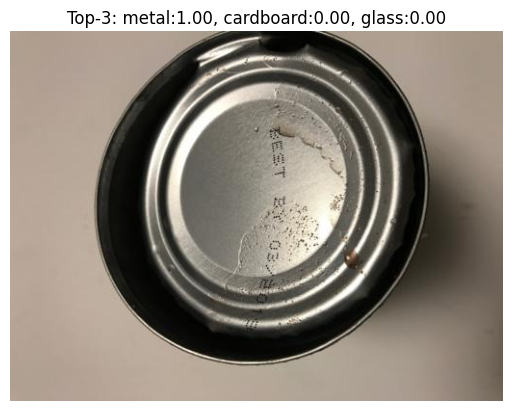

In [21]:
import tensorflow as tf, json, numpy as np, random, glob
from PIL import Image
import matplotlib.pyplot as plt, os

# load saved model + labels
m = tf.keras.models.load_model("/content/waste_classifier_export/waste_classifier.keras")
with open("/content/waste_classifier_export/labels.json") as f: classes = json.load(f)

IMG_SIZE=(224,224)

def predict_img(path):
    img = Image.open(path).convert("RGB").resize(IMG_SIZE)
    x = np.array(img)/255.0
    x = tf.keras.applications.efficientnet.preprocess_input(x[None]*255.0)
    p = m.predict(x, verbose=0)[0]
    top = sorted(list(zip(classes, p)), key=lambda t: t[1], reverse=True)[:3]
    plt.imshow(Image.open(path)); plt.axis("off")
    plt.title("Top-3: " + ", ".join([f"{c}:{prob:.2f}" for c,prob in top]))
    plt.show()

# pick a random test image and classify
test_root = "/content/waste_data/test"
any_img = random.choice(glob.glob(os.path.join(test_root, "*", "*.jpg")))
print("Using:", any_img)
predict_img(any_img)

In [22]:
# --- Robust single-image predict with center-crop + TTA + confidence gate ---
import numpy as np, tensorflow as tf
from PIL import Image

IMG_SIZE = (224, 224)       # keep same as training
CONF_TH = 0.55              # show "low confidence" if below

def _preprocess(batch_np):
    # If you used layers.Rescaling(1./255) in training, keep this:
    return batch_np.astype("float32") / 255.0
    # If you used EfficientNet preprocess_input instead, swap to:
    # from tensorflow.keras.applications.efficientnet import preprocess_input
    # return preprocess_input(batch_np.astype("float32"))

def _center_crop_resize(pil_img, size=IMG_SIZE):
    pil_img = pil_img.convert("RGB")
    w,h = pil_img.size
    scale = max(size[0]/h, size[1]/w)     # keep aspect
    pil_img = pil_img.resize((int(w*scale), int(h*scale)))
    left = (pil_img.width - size[1])//2
    top  = (pil_img.height - size[0])//2
    return pil_img.crop((left, top, left+size[1], top+size[0]))

def _tta_batch(pil_img):
    x = np.array(_center_crop_resize(pil_img))
    flips = [x, np.fliplr(x), np.flipud(x)]
    batch = np.stack(flips, axis=0)
    return _preprocess(batch)

def predict_img(path):
    img = Image.open(path)
    batch = _tta_batch(img)
    probs = best_model.predict(batch, verbose=0).mean(axis=0)
    top3 = probs.argsort()[-3:][::-1]
    print("Top-3:", ", ".join(f"{classes[i]}:{probs[i]:.2f}" for i in top3))
    if probs.max() < CONF_TH:
        print("Low confidence → likely mixed/multi-object image (domain mismatch).")

In [28]:
from google.colab import files
up = files.upload()  # choose JPG/PNG from your PC

for name in up.keys():
    predict_img(name)


Saving cardboard.jpg to cardboard.jpg
Top-3: cardboard:1.00, paper:0.00, trash:0.00


In [24]:
import json, os, tensorflow as tf
from tensorflow import keras

MODEL_DIR = "/content/waste_classifier_export"
best_model = keras.models.load_model(os.path.join(MODEL_DIR, "waste_classifier.keras"))
CLASSES = json.load(open(os.path.join(MODEL_DIR, "labels.json")))  # <-- use this, not dir listing
print("CLASSES:", CLASSES)


CLASSES: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [25]:
import numpy as np
from PIL import Image

IMG_SIZE = (224,224)
USE_EFFNET_PREPROCESS = False  # set True ONLY if you used EfficientNet preprocess in training
CONF_TH = 0.55

if USE_EFFNET_PREPROCESS:
    from tensorflow.keras.applications.efficientnet import preprocess_input
    def _prep(x): return preprocess_input(x.astype("float32"))
else:
    def _prep(x): return x.astype("float32")/255.0

def _center_crop_resize(pil):
    pil = pil.convert("RGB")
    w,h = pil.size
    s = max(IMG_SIZE[0]/h, IMG_SIZE[1]/w)
    pil = pil.resize((int(w*s), int(h*s)))
    L,T = (pil.width-IMG_SIZE[1])//2, (pil.height-IMG_SIZE[0])//2
    return pil.crop((L,T,L+IMG_SIZE[1],T+IMG_SIZE[0]))

def predict_img(path):
    img = Image.open(path)
    x = np.array(_center_crop_resize(img))
    batch = np.stack([x, np.fliplr(x), np.flipud(x)], axis=0)
    batch = _prep(batch)
    p = best_model.predict(batch, verbose=0).mean(axis=0)
    top = p.argmax()
    print("Top-3:", ", ".join(f"{CLASSES[i]}:{p[i]:.2f}" for i in p.argsort()[-3:][::-1]))
    if p[top] < CONF_TH:
        print("Low confidence → likely mixed/unalike image.")
    return {CLASSES[i]: float(p[i]) for i in range(len(CLASSES))}

In [26]:
import gradio as gr
demo = gr.Interface(fn=lambda im: predict_img(im),  # gr passes a path
                    inputs=gr.Image(type="filepath"),
                    outputs=gr.Label(num_top_classes=3),
                    title="Waste Classification (6 classes)",
                    description=", ".join(CLASSES))
demo.launch(share=False)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.
* To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>